1. linreg for EGTM, 1 engine only
2. tune theta degree
3. tune altitude + bleed ensemble

In [19]:
from deltas import *

bdu_all = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('pos == 2')
# bdu_all = pd.read_csv('./data/takeoff-merged-VQ-BGU-2.csv', parse_dates=['reportts']).query('pos == 2 and reportts >= "2019-02-01"')
bdu_all = correct(bdu_all)


In [20]:
bdu_all.shape 

(1327, 217)

Setup the experiment:

In [21]:
best_rmse = 1000
best_model = None
best_pred = None
best_x, best_y, best_th = None, None, None

alpha = 0.5
alpha_2 = 0.869

x_variants = ['n1', 'n1a', 'n2a', 'nf', 'n1_peak', 'n1a_peak', 'n1c2_peak', 'n1com_peak', 'n1max_peak', 'n2a_peak', 'nf_peak']
y_variants = ['egt', 'egt_peak', 'egtb']
theta_variants = ['oat', 'oat_peak', 't2', 't2_peak', 'tat', 'tat_peak']

hall_of_fame = []

In [22]:
def theta_correct(data, x_param, y_param, theta_param, alpha2 = alpha_2):
  theta = (data[theta_param] + 273.16) / 288.16
  data[f'{y_param}_k'] = (data[y_param] + 273.16) / (theta ** alpha2)
  data[f'{x_param}_k'] = data[x_param] / (theta ** alpha)
  return data

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

for x_param in x_variants:
  for y_param in y_variants:
    for theta_param in theta_variants:
      bdu = bdu_all.query(f"{x_param} > 0 and {y_param} > 0 and {theta_param} > -100 and egtm > -100").copy()
      x_param_k, y_param_k = f'{x_param}_k', f'{y_param}_k'
      bdu = theta_correct(bdu, x_param, y_param, theta_param)
      assert bdu.shape[0] >= 200
      baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
      egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

      X = pd.DataFrame(smooth(egtm, 0.05))
      lin_model = LinearRegression()
      lin_model.fit(X, y=bdu['egtm'])

      pred = lin_model.predict(X)
      
      rmse = root_mean_squared_error(bdu['egtm'], pred)

      if rmse < best_rmse:
        best_pred = pred
        best_rmse = rmse
        best_model = lin_model
        best_x, best_y, best_th = x_param, y_param, theta_param

      hall_of_fame.append({
        'x_param': x_param,
        'y_param': y_param, 
        'theta_param': theta_param,
        'rmse': rmse
      })


In [24]:
pd.DataFrame(hall_of_fame).sort_values('rmse')

,x_param,y_param,theta_param,rmse
172,n2a_peak,egt_peak,tat,0.854380
169,n2a_peak,egt_peak,oat_peak,0.896620
173,n2a_peak,egt_peak,tat_peak,0.898597
171,n2a_peak,egt_peak,t2_peak,0.922984
37,n2a,egt,oat_peak,1.150380
...,...,...,...,...
154,n1max_peak,egt_peak,tat,7.500976
155,n1max_peak,egt_peak,tat_peak,7.514956
153,n1max_peak,egt_peak,t2_peak,7.522683
149,n1max_peak,egt,tat_peak,7.529550


Plot best result: 

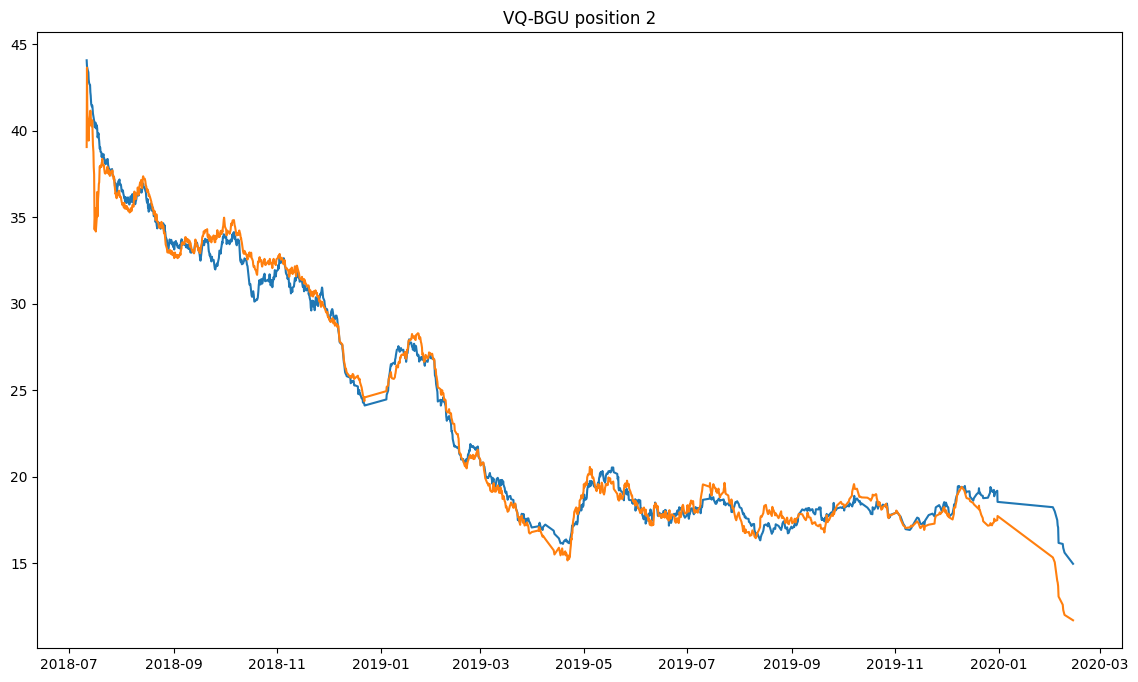

In [25]:
import matplotlib.pyplot as plt

bdu = bdu_all.query(f"n2a_peak > 0 and egt_peak > 0 and tat > -100 and egtm > -100").copy()

plt.figure(figsize=(14, 8))
plt.title(f'VQ-BGU position 2')
plt.plot(bdu['reportts'], best_pred)
plt.plot(bdu['reportts'], bdu['egtm'])
plt.show()

finetune coefficients for corrections

In [26]:
best_x, best_y, best_th

('n2a_peak', 'egt_peak', 'tat')

In [27]:
best_rmse = 1000
best_a = 1000

factor = 10_000

for a in range(8000, 9999, 1):
  bdu = theta_correct(bdu, best_x, best_y, best_th, alpha2=(a / factor))
  x_param_k, y_param_k = f'{best_x}_k', f'{best_y}_k'
  baseline = train_engine_baseline(bdu[:200], x_param_k, y_param_k)
  egtm = compute_egtm(bdu, baseline, x_param_k, y_param_k)

  X = pd.DataFrame(smooth(egtm, 0.05))
  lin_model = LinearRegression()
  lin_model.fit(X, y=bdu['egtm'])

  pred = lin_model.predict(X)
  
  rmse = root_mean_squared_error(bdu['egtm'], pred)

  if rmse < best_rmse:
    best_a = a / factor
    best_rmse = rmse

print(best_a, best_rmse)

0.8692 0.8543621197141335


**Result:**
- Alpha_2 = 0.869 (not 0.84)
- xparam = n2a_peak
- yparam = egt_peak	
- thetaparam = tat